In [28]:
from TABprocessor import *
import tokenizers
import tensorflow as tf

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer
)

In [2]:
path = "C:\\Users\\28056\\Desktop\\研究生\\Master Design\\test\\"
songs = readTAB(path)

#####0. [Angel Beats!]一番の宝物_1^8 I.xml


In [3]:
songs[0].pitch

[['4F 4C 3B- 3F 2B-', '3B-', '4C', '4F'],
 ['4C 3G 3C', '4C', '4C', '4F', '4C'],
 ['4C 3G 2A 2A', '3G', '4C', '4F', '4C'],
 ['4C 3A 3F 3C 2F', '4C 3B- 3F 3C 2F', '4C 3A 3F 3C 2F', '4C 3A 3F 3C 2F'],
 ['4F 4C 3B- 3F 2B-', '3F', '3B-', '4F'],
 ['4C 3G 3C', '4C', '4C', '4F'],
 ['4F 4D 3A 3D', '3A', '4F', '4D', '3A'],
 ['4F 4C 3A 3D', '4F 4C 3A 3F 3C 2F']]

In [4]:
songs[0].key_shift('C')

maj 7, min 2


[['4C 3G 3F 3C 2F ', '3F ', '3G ', '4C '],
 ['3G 3D 2G ', '3G ', '3G ', '4C ', '3G '],
 ['3G 3D 2E 2E ', '3D ', '3G ', '4C ', '3G '],
 ['3G 3E 3C 2G 2C ', '3G 3F 3C 2G 2C ', '3G 3E 3C 2G 2C ', '3G 3E 3C 2G 2C '],
 ['4C 3G 3F 3C 2F ', '3C ', '3F ', '4C '],
 ['3G 3D 2G ', '3G ', '3G ', '4C '],
 ['4C 3A 3E 2A ', '3E ', '4C ', '3A ', '3E '],
 ['4C 3G 3E 2A ', '4C 3G 3E 3C 2G 2C ']]

In [24]:
def tokenizer_preprocess(measurepitch):
    '''
    由于huggingface的分词会把类似4B4C这种带数字的分开，因此把数字和升降号换成字母
    '''
    xila = ['t', 'u', 'v', 'w', 'x', 'y', 'z', 'j', 'k'] 
    sentence = ''
    for cunum, cu in enumerate(measurepitch):
        if 'SUS' in cu or 'R' in cu:
            cu = cu.replace(' ', '')
            sentence += cu
            sentence += ' '
        else:
            notes = cu.split()
            for notenum, note in enumerate(notes):
                notes[notenum] = xila[int(note[0])] + note[1:]
                if len(note) > 2:
                    if note[-1] == '#':
                        notes[notenum] = notes[notenum][0:2] + 'j' 
                    elif note[-1] == '-':
                        notes[notenum] = notes[notenum][0:2] + 'k' 

            for note in notes:
                sentence += note
            sentence += ' '
    return sentence[0:-1]
            
def tokenizer_deprocess(sentence):
    '''
    希腊字母的逆变换
    '''
    measure = []
    xila = ['t', 'u', 'v', 'w', 'x', 'y', 'z', 'j', 'k']
    octave = [' 0', ' 1', ' 2', ' 3', ' 4', ' 5', ' 6', '#', '-']
    cus = sentence.split()
    for cu in cus:
        for i in range(len(xila)):
            cu = cu.replace(xila[i], octave[i])
        cu = cu[1:]
        measure.append(cu)
    return measure

#测试希腊字母化与逆变换
measures = songs[0].vectorization().pitch

for measure in measures:
    for i in range(len(measure)):
        measure[i] = measure[i].replace('__', 'SUS')
        
    print('original measure: {}'.format(measure))
    print('transfered measure: {}'.format(tokenizer_preprocess(measure)))
    print('detransfered measure: {}'.format(tokenizer_deprocess(tokenizer_preprocess(measure))))
    print()
    

original measure: ['4F 4C 3B- 3F 2B-', 'SUS', 'SUS', 'SUS', '3B-', 'SUS', '4C', 'SUS', 'SUS', 'SUS', '4F', 'SUS', 'SUS', 'SUS', 'SUS', 'SUS']
transfered measure: xFxCwBkwFvBk SUS SUS SUS wBk SUS xC SUS SUS SUS xF SUS SUS SUS SUS SUS
detransfered measure: ['4F 4C 3B- 3F 2B-', 'US', 'US', 'US', '3B-', 'US', '4C', 'US', 'US', 'US', '4F', 'US', 'US', 'US', 'US', 'US']

original measure: ['4C 3G 3C', 'SUS', 'SUS', 'SUS', '4C', 'SUS', '4C', 'SUS', 'SUS', 'SUS', '4F', 'SUS', 'SUS', 'SUS', '4C', 'SUS']
transfered measure: xCwGwC SUS SUS SUS xC SUS xC SUS SUS SUS xF SUS SUS SUS xC SUS
detransfered measure: ['4C 3G 3C', 'US', 'US', 'US', '4C', 'US', '4C', 'US', 'US', 'US', '4F', 'US', 'US', 'US', '4C', 'US']

original measure: ['4C 3G 2A 2A', 'SUS', 'SUS', 'SUS', '3G', 'SUS', '4C', 'SUS', 'SUS', 'SUS', '4F', 'SUS', 'SUS', 'SUS', '4C', 'SUS']
transfered measure: xCwGvAvA SUS SUS SUS wG SUS xC SUS SUS SUS xF SUS SUS SUS xC SUS
detransfered measure: ['4C 3G 2A 2A', 'US', 'US', 'US', '3G', 'US', '4C

In [18]:
def song_greek(song):
    '''
    对多个小节进行希腊字母化并组合成句
    '''
    song_sentence = ''
    for measure in song:
        song_sentence += tokenizer_preprocess(measure)
        song_sentence += ', '

    song_sentence = song_sentence[0:-2]
    return song_sentence

sub_dataset = readTAB('C:\\Users\\28056\\Desktop\\研究生\\AnimeTAB\\AnimeTAB\\clips\\')

#####0. [Air]てんとう虫(瓢虫)_14^21C.xml
#####1. [Air]てんとう虫(瓢虫)_2^5I.xml
#####2. [Air]てんとう虫(瓢虫)_42^49B.xml
#####3. [Air]てんとう虫(瓢虫)_6^13A.xml
#####4. [Air]回想录_9^20B.xml
#####5. [Air]夢語り_1^8A.xml
#####6. [Air]夢語り_9^16B.xml
#####7. [Air]银色_16^27B.xml
#####8. [Air]鸟之诗_10^27B.xml
#####9. [Air]鸟之诗_1^9I.xml
#####10. [Air]鸟之诗_28^43A.xml
#####11. [Air]鸟之诗_44^58C.xml
#####12. [Angel Beats!]Brave Song_16^25C.xml
#####13. [Angel Beats!]Brave Song_1^15A.xml
#####14. [Angel Beats!]Brave Song_26^49B.xml
#####15. [Angel Beats!]一番の宝物_1^8 I.xml
#####16. [Angel Beats!]一番の宝物_9^24 A.xml
#####17. [Beck]Face_13^23A.xml
#####18. [Beck]Face_25^33B.xml
#####19. [CLANNAD]メグメル(幻想)_1^15I.xml
#####20. [CLANNAD]メグメル(幻想)_23^30A.xml
#####21. [CLANNAD]メグメル(幻想)_31^49B.xml
#####22. [CLANNAD]东风_10^26A.xml
#####23. [CLANNAD]东风_1^9I.xml
#####24. [CLANNAD]团子大家族_25^32C.xml
#####25. [CLANNAD]团子大家族_33^48B.xml
#####26. [CLANNAD]团子大家族_9^24A.xml
#####27. [CLANNAD]欢乐岛_1^15I.xml
#####28. [CLANNAD]欢乐岛_24^34A.xml
#####29. [CLANNAD]欢乐岛_35^42C.

In [26]:
sentences = []
for i, song in enumerate(sub_dataset):
    song.pitch = song.key_shift('C')
    sentence = song_greek(song.vectorization().pitch)
    sentences.append(sentence)
  

maj 1, min 2
maj 0, min 0
maj 3, min 1
maj 7, min 2
maj 7, min 3
maj 2, min 0
maj 1, min 2
maj 6, min 0
maj 1, min 8
maj 3, min 2
maj 4, min 10
maj 5, min 8
maj 7, min 2
maj 2, min 3
maj 6, min 7
maj 7, min 2
maj 3, min 3
maj 6, min 0
maj 1, min 2
maj 5, min 6
maj 3, min 6
maj 11, min 1
maj 9, min 13
maj 5, min 5
maj 3, min 0
maj 4, min 2
maj 0, min 8
maj 5, min 6
maj 5, min 5
maj 2, min 0
maj 1, min 1
maj 6, min 6
maj 3, min 1
maj 2, min 6
maj 1, min 3
maj 1, min 3
maj 1, min 1
maj 3, min 1
maj 7, min 4
maj 3, min 2
maj 4, min 1
maj 4, min 4
maj 6, min 6
maj 3, min 2
maj 3, min 10
maj 4, min 7
maj 2, min 3
maj 0, min 1
maj 1, min 4
maj 0, min 1
maj 0, min 2
maj 0, min 4
maj 0, min 0
maj 0, min 1
maj 2, min 7
maj 11, min 8
maj 8, min 12
maj 2, min 0
maj 7, min 2
maj 4, min 7
maj 0, min 2
maj 2, min 1
maj 1, min 1
maj 0, min 4
maj 1, min 6
maj 1, min 1
maj 12, min 8
maj 8, min 2
maj 5, min 2
maj 10, min 3
maj 4, min 5
maj 2, min 1
maj 6, min 5
maj 4, min 5
maj 6, min 5
maj 2, min 3
maj 

In [29]:
music_tokenizer = Tokenizer(models.BPE())
music_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
#music_tokenizer.pre_tokenizer.pre_tokenize_str(sentence1)

trainer = trainers.BpeTrainer(vocab=5000, special_tokens=["END"])
music_tokenizer.train_from_iterator(sentences, trainer=trainer)
music_tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)

In [30]:
a = music_tokenizer.encode('xFxCwBkwFvBk SUS SUS SUS wBk SUS')
a.ids

[236, 52, 46, 54, 22, 22, 22, 32, 22]

In [32]:
string_tokenized = ''
for sen in sentences:
    string_tokenized += sen
    
string_tokenized = music_tokenizer.encode(string_tokenized).ids

In [33]:
examples = []
block_size = 100
BATCH_SIZE = 8
BUFFER_SIZE = 1000
for i in range(0, len(string_tokenized) - block_size + 1, block_size):
    examples.append(string_tokenized[i:i + block_size])

In [34]:
inputs, labels = [], []
for ex in examples:
    inputs.append(ex[:-1])
    labels.append(ex[1:])
dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [36]:
for i in dataset.take(1):
    print(i)

(<tf.Tensor: shape=(8, 99), dtype=int32, numpy=
array([[  22,   22,   22,   22,   22,   22,   22,   22,   22,   22,   22,
          22,    1,  174,   22,   63,   22,   63,   22,  184,   22,   63,
          22,   48,   22,   22,   22,   22,   22,   22,   22,   22,   22,
          22,   22,   22,   22,    1,   93,   22,   37,   22,   37,   22,
          89,   22,   82,   22,   33,   22,   22,   22,   22,   22,   22,
          22,   22,   22,   22,   22,   22,   22,    1,   89,   22,   30,
          22,   30,   22,  468,   22,   64,   22,  115,   22,   22,   22,
          22,   22,   22,   22,   22,   22,   22,   22,   22,   22,    1,
         166,   22,   30,   22,   30,   22, 2118,   22,   25,   22,   29],
       [  22,   22,   22,   28,   22,   22,   22,   85,   22,   22,   22,
          27,   22,   22,   22,    1,   87,   22,   27,   22,   25,   22,
          22,   22,   85,   22,   22,   22,   29,   22,   22,   22,    1,
         177,   22,   22,   22,   28,   22,   22,   22,  185,  

In [38]:
from transformers import GPT2Config, TFGPT2LMHeadModel
config = GPT2Config(
  vocab_size=5000
)

# creating the model
model = TFGPT2LMHeadModel(config)

# defining our optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
# definining our loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# compiling the model
model.compile(optimizer=optimizer, loss=[loss, *[None] * model.config.n_layer], metrics=[metric])
num_epoch = 50
history = model.fit(dataset, epochs=num_epoch)

Epoch 1/50
137/137 [==============================] - 36s 204ms/step - loss: 3.1301 - accuracy: 0.5547
Epoch 2/50
137/137 [==============================] - 29s 209ms/step - loss: 2.5451 - accuracy: 0.5594
Epoch 3/50
137/137 [==============================] - 29s 209ms/step - loss: 2.4463 - accuracy: 0.5624
Epoch 4/50
137/137 [==============================] - 28s 208ms/step - loss: 2.3694 - accuracy: 0.5673
Epoch 5/50
137/137 [==============================] - 28s 207ms/step - loss: 2.2913 - accuracy: 0.5742
Epoch 6/50
137/137 [==============================] - 28s 207ms/step - loss: 2.2110 - accuracy: 0.5847
Epoch 7/50
137/137 [==============================] - 28s 204ms/step - loss: 2.1295 - accuracy: 0.5949
Epoch 8/50
137/137 [==============================] - 28s 204ms/step - loss: 2.0549 - accuracy: 0.6030
Epoch 9/50
137/137 [==============================] - 28s 205ms/step - loss: 1.9854 - accuracy: 0.6103
Epoch 10/50
137/137 [==============================] - 28s 204ms/step - l

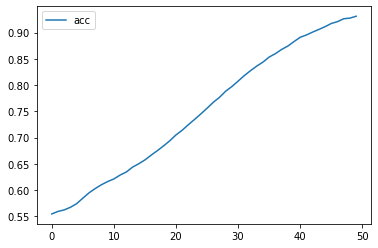

In [41]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.legend()

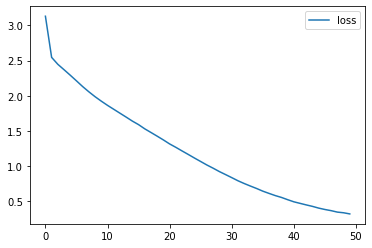

In [42]:
plt.plot(history.history['loss'], label='loss')
plt.legend()

In [52]:
text = "wFwD xC xC wF xC"
# encoding the input text
input_ids = music_tokenizer.encode(text).ids
input_ids = tf.reshape(input_ids, [1, -1])
# getting out output
beam_output = model.generate(
  input_ids,
  max_length = 50,
  num_beams = 5,
  temperature = 0.7,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [61]:
def song_degeek(str1):
    measures = str1.split(', ')
    for measure in measures:
        print(tokenizer_deprocess(measure))
        
sample = music_tokenizer.decode(beam_output[0])       
song_degeek(sample)

['3F 3D', ' 4C', ' 4C', ' 3F', ' 4C', 'SUS', ' 3F', 'SUS', ' 4C', ' 4D', 'SUS', 'SUS', ' 3E', 'SUS', ' 3D', 'SUS']
[' 3A 2F', 'SUS', ' 3B', ' 3G', ' 3A', 'SUS', ' 3G', 'SUS', ' 4D', ' 4E', 'SUS', ' 2G', ' 3G', ' 3B', ' 4C']
[' 3G 2E', 'SUS', ' 2B', ' 3E', ' 3G 3D', ' 3A', ' 2B', 'SUS', ' 3G 3E', 'SUS', ' 2E', ' 3G', ' 4C', ' 3E', ' 2E', ' 3E', '']


In [62]:
tokenizer_deprocess(text)

['3F 3D', '4C', '4C', '3F', '4C']

In [47]:
tokenizer_preprocess(song.pitch[0])

In [64]:
from transformers import WEIGHTS_NAME, CONFIG_NAME
import os
output_dir = './model_bn_custom/'
# creating directory if it is not present
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)
# save model and model configs
model.save_pretrained(output_dir)
model_to_save.config.to_json_file(output_config_file)
# save tokenizer
music_tokenizer.save('music_tokenizer.json')